# Student Sample 1

## 廖聿鋆

## 4.1.

In [ ]:
import pandas as pd
import re
from ckip_transformers.nlp import CkipWordSegmenter
import preprocessor as p

In [ ]:
dcard = pd.read_csv('dcard-top100.csv')

## text cleaning

In [ ]:
def clean_text(lst):
    cleaned = []
    p.set_options(p.OPT.URL)
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    for text in lst:
        cleaned_text = re.sub("[\s+\.\!\/_,$%^*(+\"\']+|[+——！，。？「」《》：?、~@#￥%……&*->（）(）[]", "",text).replace('\n',"")
        cleaned_text = emoji_pattern.sub(r'', cleaned_text) #remove emojis
        cleaned_text = p.clean(cleaned_text) #remove urls
        cleaned_text = re.sub("[A-Za-z]", "",cleaned_text) #remove English alphabets
        cleaned.append(cleaned_text)
    return cleaned

In [ ]:
dcard['cleaned_content'] = clean_text(dcard['content'])

## tokenization and stopwords removal

The tokenzization part I had to do it in google colab because the ckip tokenizer runs too slow without a GPU. I first tokenized and removed the stopwords in the content there, then saved the results as a pickle "tokenized.pkl" and loaded it back here.

In [ ]:
tokenized = pd.read_pickle('tokenized.pkl')

In [ ]:
dcard['tokenized'] = tokenized

In [ ]:
stopwords = pd.read_csv('chi_stopwords.txt')

In [ ]:
vocab=[]
for lems in dcard['tokenized']:
    vocab += lems

In [ ]:
clean_vocab = []
for lem in vocab:
    if lem not in stopwords['$'].values:
        clean_vocab.append(lem)

In [ ]:
from collections import Counter
word_count = pd.DataFrame.from_dict(Counter(clean_vocab), orient='index').reset_index()

In [ ]:
word_count.columns=['LEMMA','COUNT']
word_count.sort_values(by=['COUNT'], ascending= False).reset_index(drop=True)[:20]

,LEMMA,COUNT
0,會,218
1,說,205
2,想,118
3,真的,116
4,沒,102
5,天,100
6,次,96
7,沒有,93
8,覺得,89
9,知道,70


## 4.2.

For ner extraction, I also had to do it with the help of colab's GPU. The code I used is presented below.

In [ ]:
from ckip_transformers.nlp import CkipNerChunker
ner_driver = CkipNerChunker(device=0)

In [ ]:
ner = ner_driver(dcard_cleaned['content'], use_delim=True)

In [ ]:
ORG_GPE = []
for sentence_ner in ner:
  for entity in sentence_ner:
    if entity.ner in ["GPE","ORG"]:
      ORG_GPE.append(entity.word)

In [ ]:
ner = pd.read_pickle('ner.pkl').tolist()

In [ ]:
from collections import Counter
word_count = pd.DataFrame.from_dict(Counter(ner), orient='index').reset_index()

In [ ]:
word_count.columns=['LEMMA','COUNT']
word_count.sort_values(by=['COUNT'], ascending= False).reset_index(drop=True)[:20]

,LEMMA,COUNT
0,台灣,23
1,日本,18
2,台南,7
3,台,6
4,英國,5
5,聖圭,4
6,韓國,4
7,沖繩,4
8,台中,4
9,台北,3


## 4.3.

In [ ]:
import spacy

In [ ]:
nlp = spacy.load("zh_core_web_sm")

In [ ]:
spacy_vocab = []
for sent in dcard_cleaned['content']:
  doc = nlp(sent)
  for token in doc:
    if token.pos_ in ["NOUN", "VERB"] and len(token.text) >=2:
      spacy_vocab.append(token.text)

In [ ]:
spacy_vocab = pd.read_pickle('spacy_vocab.pkl')

In [ ]:
word_count = pd.DataFrame.from_dict(Counter(spacy_vocab), orient='index').reset_index()
word_count.columns=['N-V','COUNT']
word_count.sort_values(by=['COUNT'], ascending= False).reset_index(drop=True)[:20]

,N-V,COUNT
0,沒有,79
1,知道,70
2,看到,67
3,朋友,54
4,喜歡,47
5,分享,43
6,男友,42
7,工作,40
8,感覺,37
9,希望,35


In [ ]:
## wordcloud
from wordcloud import WordCloud, ImageColorGenerator
import numpy as np
from PIL import Image


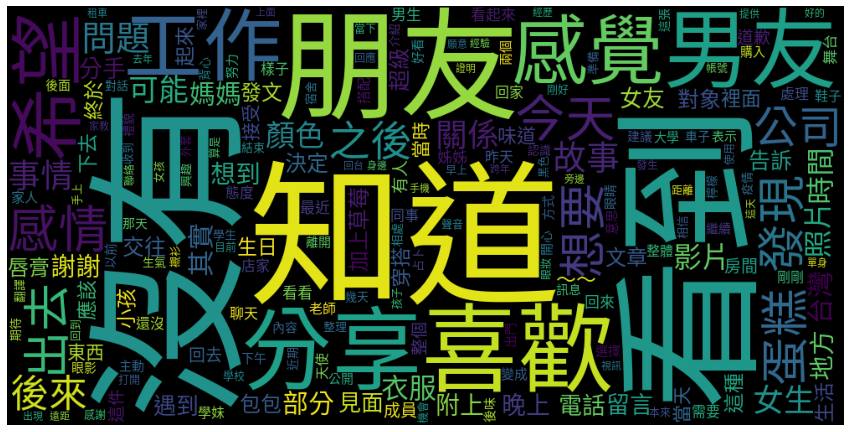

In [ ]:
from collections import Counter
font = 'SourceHanSansTW-Regular.otf'

word_could_dict=Counter(spacy_vocab)
wordcloud = WordCloud(width = 1000, height = 500, font_path=font).generate_from_frequencies(word_could_dict)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()



## 4.4.

In [ ]:
subj_pred = []
for sent in dcard_cleaned['cleaned_content']:
  doc = nlp(sent)
  for i in range(len(doc)):
    if (doc[i].dep_ == "nsubj") and (doc[i+1].text not in stopwords.values):
      subj_pred.append(doc[i].text +"_"+ doc[i+1].text)

In [ ]:
subj_pred = pd.read_pickle('subj_pred.pkl')

In [ ]:
word_count = pd.DataFrame.from_dict(Counter(subj_pred), orient='index').reset_index()
word_count.columns=['SUBJ_PRED','COUNT']
word_count.sort_values(by=['COUNT'], ascending= False).reset_index(drop=True)[:20]

,SUBJ_PRED,COUNT
0,我_真的,15
1,我_想,10
2,我_覺,9
3,他_真的,7
4,他_沒有,6
5,我_知道,6
6,我_喜歡,6
7,他_覺,5
8,我_看到,5
9,我_剛剛,4
